<a href="https://colab.research.google.com/github/robertopaulo/CienciaDeDados/blob/main/Hospital_ratings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descrição do Problema

O dataset "Hospital General Information", do CMS, reúne dados sobre hospitais dos EUA, incluindo tipo, propriedade, serviços oferecidos e métricas de desempenho. O problema proposto é prever a avaliação geral de um hospital (de 1 a 5 estrelas) com base em suas características operacionais e institucionais. Isso permite identificar os fatores que mais influenciam a qualidade hospitalar, auxiliando na gestão, no planejamento de políticas públicas e na transparência para pacientes e profissionais de saúde.

# Importância

Entender os fatores que influenciam a avaliação dos hospitais é essencial para melhorar a qualidade dos serviços de saúde, apoiar gestores e formuladores de políticas públicas, e fornecer informações úteis aos pacientes. A análise desses dados contribui para decisões mais eficientes, alocação adequada de recursos e maior transparência no sistema de saúde.

# Aplicabilidade

Os resultados dessa análise podem ser aplicados na gestão hospitalar, em sistemas de apoio à decisão, no planejamento de políticas públicas de saúde, e na identificação de padrões de desempenho entre hospitais, contribuindo para melhorias nos serviços e na experiência do paciente.



# Análise

## Bibliotecas e Arquivo

In [1]:
# Bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Upload do arquivo CSV
from google.colab import files
uploaded = files.upload()


Saving HospInfo.csv to HospInfo.csv


## Visualização Inicial

In [35]:
#Arquivo CSV carregado
df = pd.read_csv("HospInfo.csv")
df.head()



,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote,Location
0,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,NaN,Same as the national average,NaN,Same as the national average,NaN,Above the national average,NaN,Below the national average,NaN,"2505 U S HIGHWAY 431 NORTH\nBOAZ, AL\n"
1,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,Proprietary,...,NaN,Same as the national average,NaN,Same as the national average,NaN,Above the national average,NaN,Same as the national average,NaN,"200 MED CENTER DRIVE\nFORT PAYNE, AL\n"
2,10032,WEDOWEE HOSPITAL,209 NORTH MAIN STREET,WEDOWEE,AL,36278,RANDOLPH,2563572111,Acute Care Hospitals,Government - Hospital District or Authority,...,NaN,Not Available,Results are not available for this reporting p...,Same as the national average,NaN,Same as the national average,NaN,Not Available,Results are not available for this reporting p...,"209 NORTH MAIN STREET\nWEDOWEE, AL\n"
3,10095,HALE COUNTY HOSPITAL,508 GREEN STREET,GREENSBORO,AL,36744,HALE,3346243024,Acute Care Hospitals,Government - Local,...,Results are not available for this reporting p...,Not Available,Results are not available for this reporting p...,Below the national average,NaN,Same as the national average,NaN,Not Available,Results are not available for this reporting p...,"508 GREEN STREET\nGREENSBORO, AL\n"
4,10131,CRESTWOOD MEDICAL CENTER,ONE HOSPITAL DR SE,HUNTSVILLE,AL,35801,MADISON,2568823100,Acute Care Hospitals,Proprietary,...,NaN,Same as the national average,NaN,Same as the national average,NaN,Same as the national average,NaN,Same as the national average,NaN,"ONE HOSPITAL DR SE\nHUNTSVILLE, AL\n"


## Informações gerais e limpeza inicial

In [16]:
# 1. Número de variáveis
print(f"Número de variáveis (colunas): {df.shape[1]}")

# 2. Tipos e informações básicas
print("\nInformações gerais sobre as variáveis:")
print(df.info())

# 3. Estatísticas das variáveis numéricas
print("\nEstatísticas descritivas das variáveis numéricas:")
print(df.describe())

# 4. Variáveis categóricas principais - Distribuição dos valores
categorical_cols = [
    'Hospital Type',
    'Hospital Ownership',
    'Emergency Services',
    'Hospital overall rating'
]

for col in categorical_cols:
    print(f"\nDistribuição da variável categórica '{col}':")
    print(df[col].value_counts(dropna=False))

# 5. Exemplo de histograma para variável numérica (Número de leitos)
if 'Number of Beds' in df.columns:
    import matplotlib.pyplot as plt
    plt.hist(df['Number of Beds'].dropna(), bins=30, edgecolor='k')
    plt.title('Distribuição do Número de Leitos')
    plt.xlabel('Número de Leitos')
    plt.ylabel('Frequência')
    plt.show()

df.isnull().sum()
df.shape


Número de variáveis (colunas): 29

Informações gerais sobre as variáveis:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 29 columns):
 #   Column                                                         Non-Null Count  Dtype 
---  ------                                                         --------------  ----- 
 0   Provider ID                                                    4812 non-null   int64 
 1   Hospital Name                                                  4812 non-null   object
 2   Address                                                        4812 non-null   object
 3   City                                                           4812 non-null   object
 4   State                                                          4812 non-null   object
 5   ZIP Code                                                       4812 non-null   int64 
 6   County Name                                                    4797 non-null   object


(4812, 29)

## Seleção e pré-processamento

In [5]:
# Verificando a distribuição da variável alvo
df['Hospital overall rating'].value_counts()


,count
Hospital overall rating,
3,1761
Not Available,1245
4,939
2,678
1,107
5,82


### Filtrando e limpando

In [8]:
# Removendo registros com nota geral ausente
df = df[df['Hospital overall rating'] != 'Not Available'].copy()

# Escolhendo algumas features simples para começar
features = ['Hospital Type', 'Hospital Ownership', 'Emergency Services', 'State']
target = 'Hospital overall rating'

# Convertendo para numérico
df = df[features + [target]]
df = df.dropna()

# Codificando variáveis categóricas
le = LabelEncoder()
for col in features:
    df[col] = le.fit_transform(df[col])

# Convertendo a variável alvo para numérico após remover 'Not Available'
df[target] = pd.to_numeric(df[target])

# Divisão dos dados
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Treinamento de modelo simples

In [9]:
# Modelo básico com Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Avaliação
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))


Acurácia: 0.5077881619937694

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      0.12      0.22        24
           1       0.39      0.26      0.31       150
           2       0.46      0.62      0.53       343
           3       0.38      0.26      0.31       182
           4       0.00      0.00      0.00        12
           5       0.69      0.75      0.72       252

    accuracy                           0.51       963
   macro avg       0.49      0.33      0.35       963
weighted avg       0.50      0.51      0.49       963


Matriz de Confusão:
 [[  3   6  14   1   0   0]
 [  0  39  89   8   2  12]
 [  0  35 211  52   1  44]
 [  0  12  94  48   2  26]
 [  0   2   5   4   0   1]
 [  0   7  45  12   0 188]]


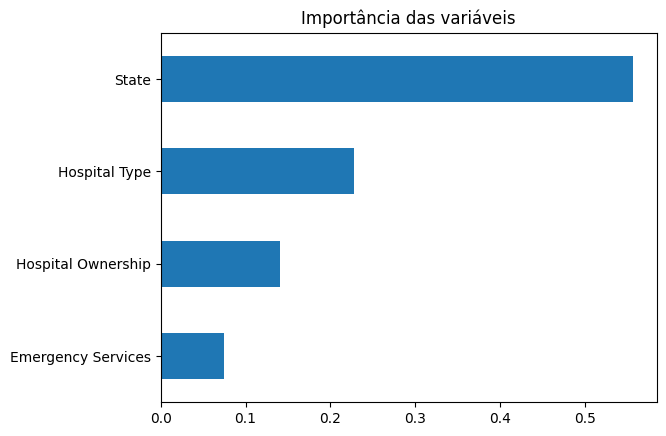

In [10]:
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', title='Importância das variáveis')
plt.show()


Treinamento e Modelo Combinado

In [19]:


# 1. Carregar dataset (já feito, substitua o nome pelo seu arquivo)
df = pd.read_csv("HospInfo.csv")

# 2. Limpeza do target (remover 'Not Available')
df = df[df['Hospital overall rating'] != 'Not Available']

# 3. Selecionar features e target
features = ['Hospital Type', 'Hospital Ownership', 'Emergency Services', 'State']
target = 'Hospital overall rating'

df = df[features + [target]].dropna()

# 4. Codificar categóricas
le_dict = {}
for col in features + [target]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # salvar para possíveis decodificações depois

X = df[features]
y = df[target]

# 5. Dividir treino/teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6. Definir modelos
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(random_state=42)
}

# 7. Avaliar com validação cruzada e depois no teste
results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    cv_acc = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy').mean()
    cv_f1 = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1_macro').mean()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='macro')
    results[name] = {
        'CV Accuracy': cv_acc,
        'CV F1 Macro': cv_f1,
        'Test Accuracy': test_acc,
        'Test F1 Macro': test_f1,
        'Classification Report': classification_report(y_test, y_pred)
    }

# 8. Mostrar resultados
for name, metrics in results.items():
    print(f"Modelo: {name}")
    print(f" - Validação Cruzada Accuracy: {metrics['CV Accuracy']:.4f}")
    print(f" - Validação Cruzada F1 Macro: {metrics['CV F1 Macro']:.4f}")
    print(f" - Teste Accuracy: {metrics['Test Accuracy']:.4f}")
    print(f" - Teste F1 Macro: {metrics['Test F1 Macro']:.4f}")
    print(f" - Relatório de Classificação:\n{metrics['Classification Report']}")
    print("-"*60)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Modelo: Random Forest
 - Validação Cruzada Accuracy: 0.4651
 - Validação Cruzada F1 Macro: 0.2925
 - Teste Accuracy: 0.5098
 - Teste F1 Macro: 0.2963
 - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.67      0.10      0.17        21
           1       0.47      0.28      0.35       136
           2       0.54      0.77      0.64       353
           3       0.41      0.27      0.33       188
           4       0.00      0.00      0.00        16

    accuracy                           0.51       714
   macro avg       0.42      0.28      0.30       714
weighted avg       0.49      0.51      0.47       714

------------------------------------------------------------
Modelo: Logistic Regression
 - Validação Cruzada Accuracy: 0.4921
 - Validação Cruzada F1 Macro: 0.1325
 - Teste Accuracy: 0.4944
 - Teste F1 Macro: 0.1343
 - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Visualização

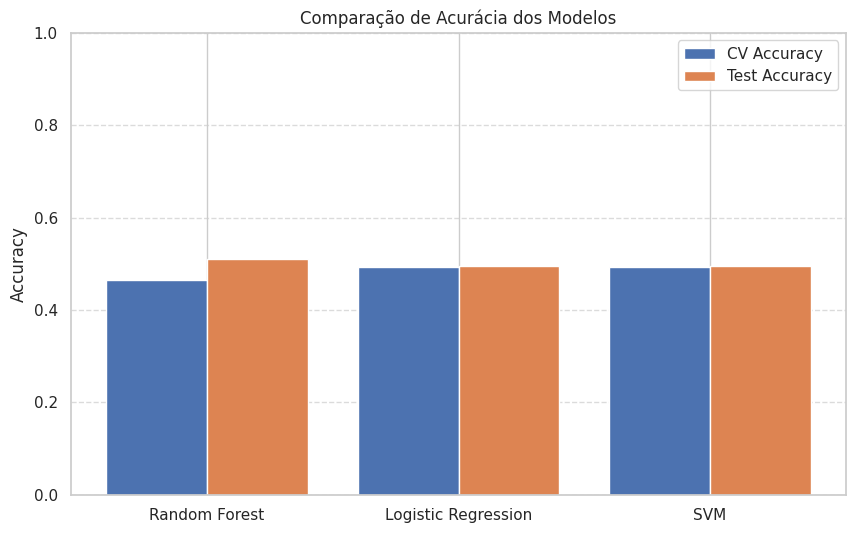

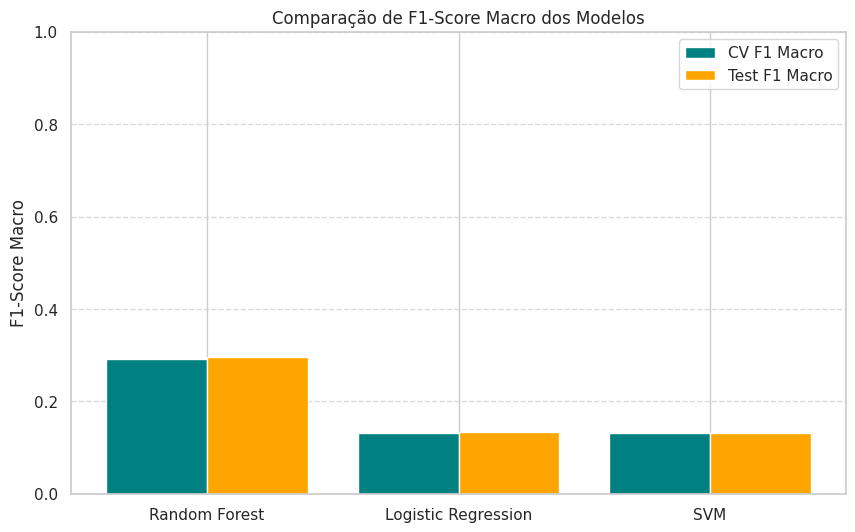

In [43]:
# Listar os nomes dos modelos
model_names = list(results.keys())

# Extrair métricas
cv_acc = [results[m]['CV Accuracy'] for m in model_names]
cv_f1 = [results[m]['CV F1 Macro'] for m in model_names]
test_acc = [results[m]['Test Accuracy'] for m in model_names]
test_f1 = [results[m]['Test F1 Macro'] for m in model_names]

# 1. Gráfico de Acurácia
plt.figure(figsize=(10,6))
x = range(len(model_names))
plt.bar(x, cv_acc, width=0.4, label='CV Accuracy', align='center')
plt.bar([i + 0.4 for i in x], test_acc, width=0.4, label='Test Accuracy', align='center')
plt.xticks([i + 0.2 for i in x], model_names)
plt.ylabel('Accuracy')
plt.title('Comparação de Acurácia dos Modelos')
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Gráfico de F1-Score Macro
plt.figure(figsize=(10,6))
plt.bar(x, cv_f1, width=0.4, label='CV F1 Macro', align='center', color='teal')
plt.bar([i + 0.4 for i in x], test_f1, width=0.4, label='Test F1 Macro', align='center', color='orange')
plt.xticks([i + 0.2 for i in x], model_names)
plt.ylabel('F1-Score Macro')
plt.title('Comparação de F1-Score Macro dos Modelos')
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


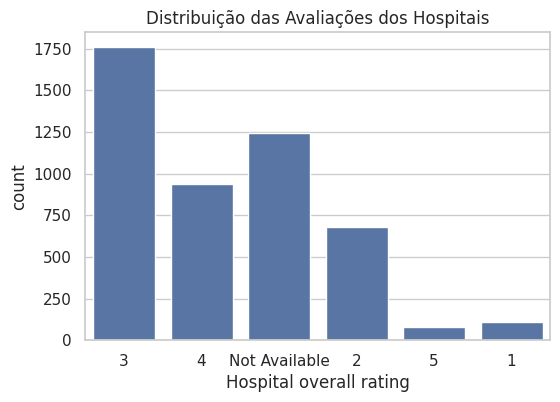

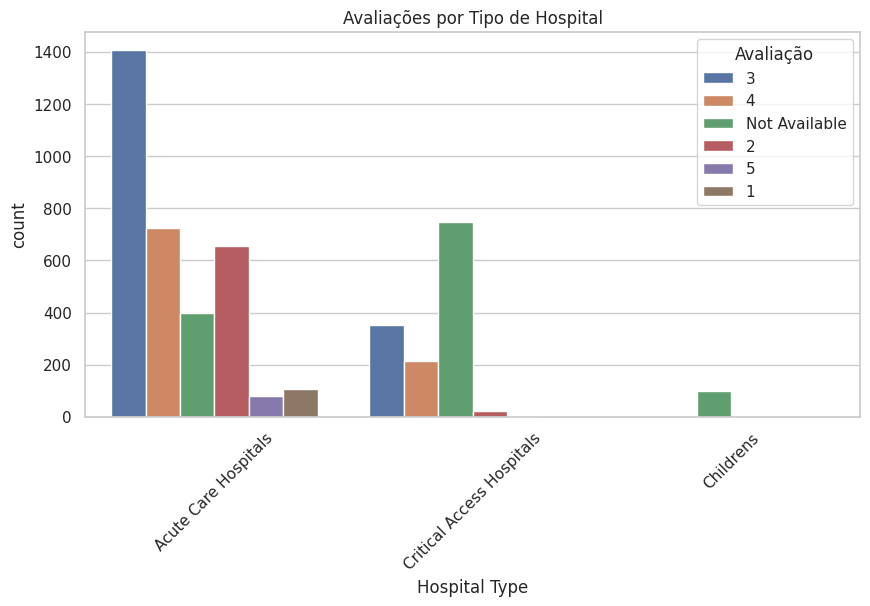

In [37]:
# Distribuição da variável alvo
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Hospital overall rating')
plt.title('Distribuição das Avaliações dos Hospitais')
plt.show()

# Gráfico de barras para variáveis categóricas vs avaliação (exemplo com Hospital Type)
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Hospital Type', hue='Hospital overall rating')
plt.title('Avaliações por Tipo de Hospital')
plt.xticks(rotation=45)
plt.legend(title='Avaliação')
plt.show()


/tmp/ipython-input-41-3952659354.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Hospital overall rating', palette="viridis")


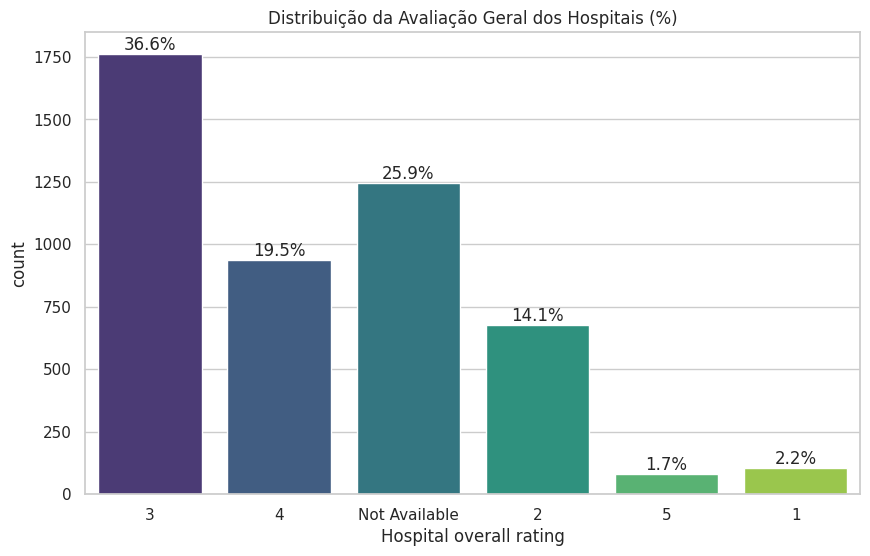

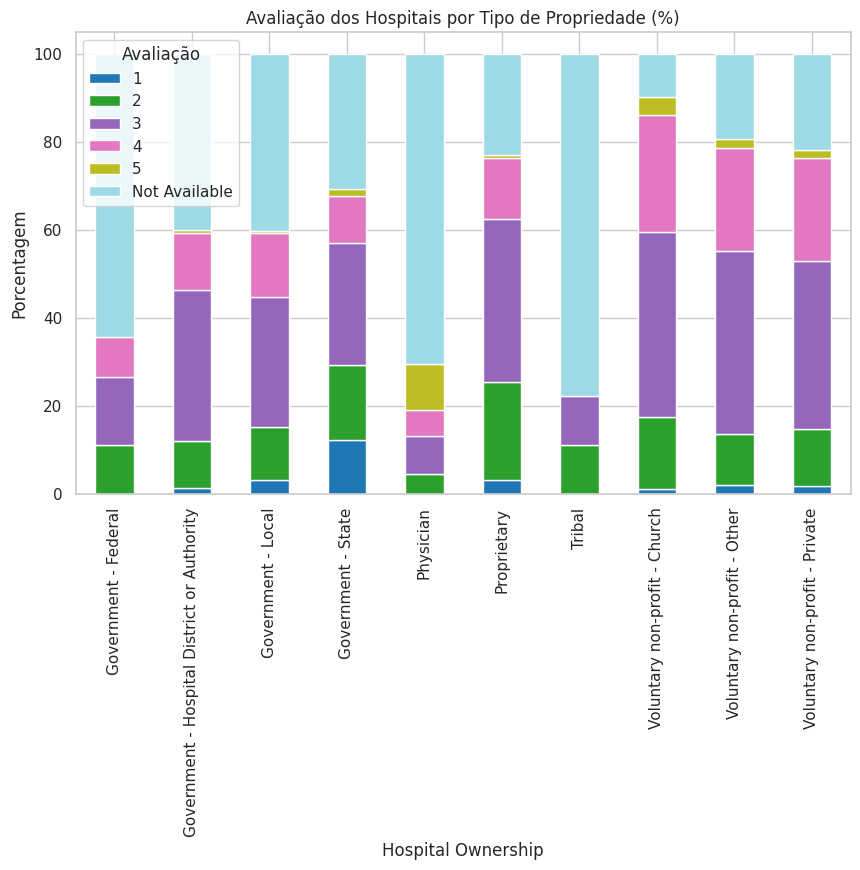

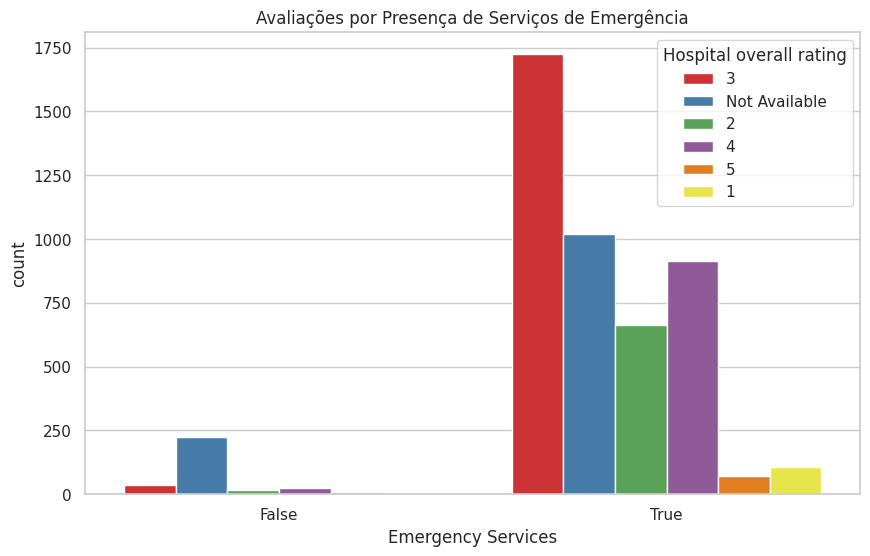

In [41]:

# Configurações gerais para os gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

# 1. Distribuição detalhada da variável alvo com porcentagens
ax = sns.countplot(data=df, x='Hospital overall rating', palette="viridis")
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')
plt.title('Distribuição da Avaliação Geral dos Hospitais (%)')
plt.show()


# 2. Gráfico de barras empilhadas: Avaliação por tipo de propriedade (Hospital Ownership)
ownership_rating = pd.crosstab(df['Hospital Ownership'], df['Hospital overall rating'], normalize='index') * 100
ownership_rating.plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Avaliação dos Hospitais por Tipo de Propriedade (%)')
plt.ylabel('Porcentagem')
plt.legend(title='Avaliação')
plt.show()

# 3. Gráfico de barras: Serviços de emergência vs Avaliação (contagem absoluta)
sns.countplot(data=df, x='Emergency Services', hue='Hospital overall rating', palette='Set1')
plt.title('Avaliações por Presença de Serviços de Emergência')
plt.show()